# Tides evaluation
## First check: Maximum amplitude map compared against TPXO 7.2 solution
What I try do achive is a comparison of maximum tidal amplitude from ROMS against the TPXO7.2 solution (provides forcing for ROMS). To do so, I compare ROMS maximum sea surface height anomaly from a hourly record of 14 days against the summation of the amplitudes over all (8) constituents from the forcing file. 

In [111]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_his_hourly.nc')
ds = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds.zeta.max('ocean_time')-ds.zeta.mean('ocean_time')

In [102]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_dataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

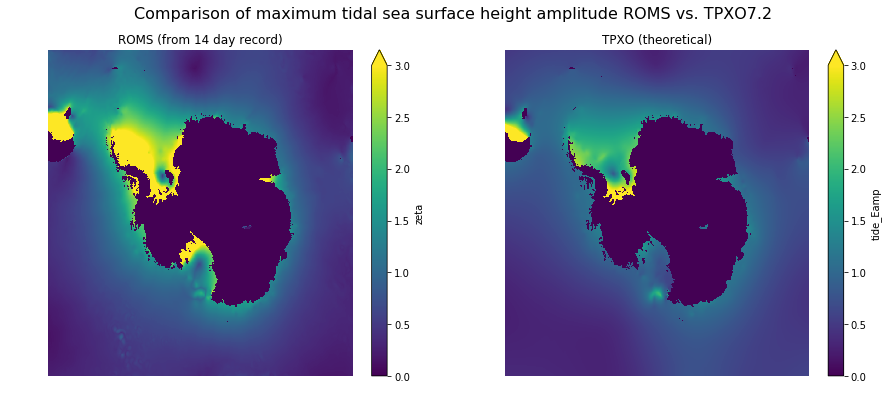

In [107]:
# plot both next to each other with same colorbounds
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=3)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=3)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

... Roms gets about two times to high under the big ice shelves. Since the height looks ok everywhere else, this might be related to the kelvin waves. Two ideas to fix this:
1. no forcing on the continental shelf
2. increase bottom/ice shelf drag, high resolution might help

## Better: Comparison of M2 and O1 amplitude maps
(others violate Rayleigh condition with just 14 day record) 

In [105]:
import ttide as tt
import numpy as np
import pandas as pd

Apply t_tide tidal harmonic analysis on every grid point and fill O1 and M2 amplitude maps in Xarray dataset

In [108]:
ds['O1_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))
ds['M2_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))

#stime = datetime(1996,12,31,1)
stime = pd.to_datetime(ds.ocean_time[0].values)

for xi in ds.xi_rho.values:
    print('processing xi: ',xi)
    for eta in ds.eta_rho.values:
        
        ds_sl = ds.isel(eta_rho=eta,xi_rho=xi)
        
        if ds_sl.zeta.isnull().values.any():
            ds.O1_ampl[eta,xi] = np.NaN
            ds.M2_ampl[eta,xi] = np.NaN
        else:
            signal = ds_sl.zeta.values
            latitude = ds_sl.lat_rho.values
            try:
                ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                ind_M2 = list(ttide_out['nameu']).index(b'M2  ')
        
                O1_ampl = ttide_out['tidecon'][ind_O1][0]
                M2_ampl = ttide_out['tidecon'][ind_M2][0]
            
                ds.O1_ampl[eta,xi] = O1_ampl
                ds.M2_ampl[eta,xi] = M2_ampl
                
            except TypeError:
                
                ds.O1_ampl[eta,xi] = np.NaN
                ds.M2_ampl[eta,xi] = np.NaN

processing xi:  0
processing xi:  1
processing xi:  2
processing xi:  3
processing xi:  4
processing xi:  5
processing xi:  6
processing xi:  7
processing xi:  8
processing xi:  9
processing xi:  10
processing xi:  11
processing xi:  12


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:620: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
processing xi:  13
processing xi:  14
processing xi:  15
processing xi:  16
processing xi:  17
processing xi:  18
processing xi:  19
processing xi:  20
processing xi:  21
processing xi:  22
processing xi:  23
processing xi:  24
processing xi:  25
processing xi:  26
processing xi:  27
processing xi:  28
processing xi:  29
processing xi:  30
processing xi:  31
processing xi:  32
processing xi:  33
processing xi:  34
processing xi:  35
processing xi:  36
processing xi:  37
processing xi:  38
processing xi:  39
processing xi:  40
processing xi:  41
processing xi:  42
processing xi:  43
processing xi:  44
processing xi:  45
processing xi:  46
processing xi:  47
processing xi:  48
processing xi:  49
processing xi:  50
processing xi:  51
processing xi:  52
processing xi:  53
processing xi:  54
processing xi:  55
processing xi:  56
processing xi:  57
processing xi:  58
processing xi:  59
processing xi:  60
processing xi:  61
processing xi:  62
processing xi:  63
pr

processing xi:  426
processing xi:  427
processing xi:  428
processing xi:  429
processing xi:  430
processing xi:  431
processing xi:  432
processing xi:  433
processing xi:  434
processing xi:  435
processing xi:  436
processing xi:  437
processing xi:  438
processing xi:  439
processing xi:  440
processing xi:  441
processing xi:  442
processing xi:  443
processing xi:  444
processing xi:  445
processing xi:  446
processing xi:  447
processing xi:  448
processing xi:  449
processing xi:  450
processing xi:  451
processing xi:  452
processing xi:  453
processing xi:  454
processing xi:  455
processing xi:  456
processing xi:  457
processing xi:  458
processing xi:  459
processing xi:  460
processing xi:  461
processing xi:  462
processing xi:  463
processing xi:  464
processing xi:  465
processing xi:  466
processing xi:  467
processing xi:  468
processing xi:  469
processing xi:  470
processing xi:  471
processing xi:  472
processing xi:  473
processing xi:  474
processing xi:  475


processing xi:  836
processing xi:  837
processing xi:  838
processing xi:  839
processing xi:  840
processing xi:  841
processing xi:  842
processing xi:  843
processing xi:  844
processing xi:  845
processing xi:  846
processing xi:  847
processing xi:  848
processing xi:  849
processing xi:  850
processing xi:  851
processing xi:  852
processing xi:  853
processing xi:  854
processing xi:  855
processing xi:  856
processing xi:  857
processing xi:  858
processing xi:  859
No predictions with this SNR
No predictions with this SNR


Plot against TPXO O1 and M2 amplitude maps

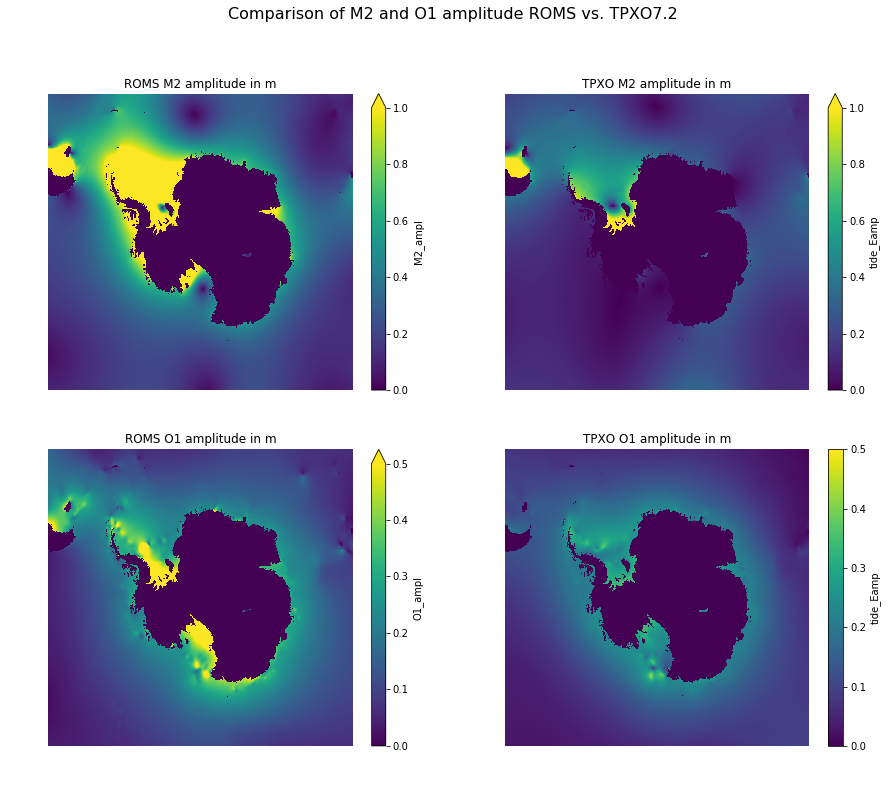

In [109]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude ROMS vs. TPXO7.2',fontsize=16)
ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds.O1_ampl.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

In [104]:
ds.M2_ampl.fillna(0).mean()

AttributeError: 'Dataset' object has no attribute 'M2_ampl'

## No forcing under the ice shelves
Dave suggested that the to high tides might come from some model amplification under the ice shelves. Therefore I look at an experiment, without tidal surface forcing where ice shelf is present.

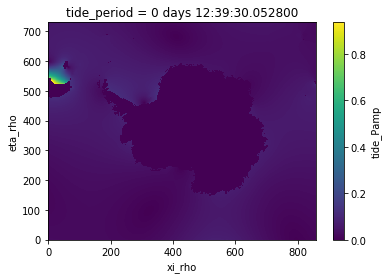

In [119]:
#mask tidal forcing
pott_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_ptds_large.nc')
pott_ds = xr.open_dataset(pott_path)
grid_path =  os.path.join(os.pardir,'data','raw','waom10_full_forcing','Data','waom10','waom10_grd_large.nc')
grid_ds = xr.open_dataset(grid_path)
Pamp_masked = pott_ds.tide_Pamp.where((grid_ds.zice.values == 0.0 ,0.0)
plt.clf()
Pamp_masked[2].plot()
plt.show()

In [120]:
out_path = os.path.join(pott_path,os.pardir,'waom10_ptds_masked.nc')
pott_ds['tide_Pamp']=Pamp_masked
pott_ds.to_netcdf(out_path,'w')

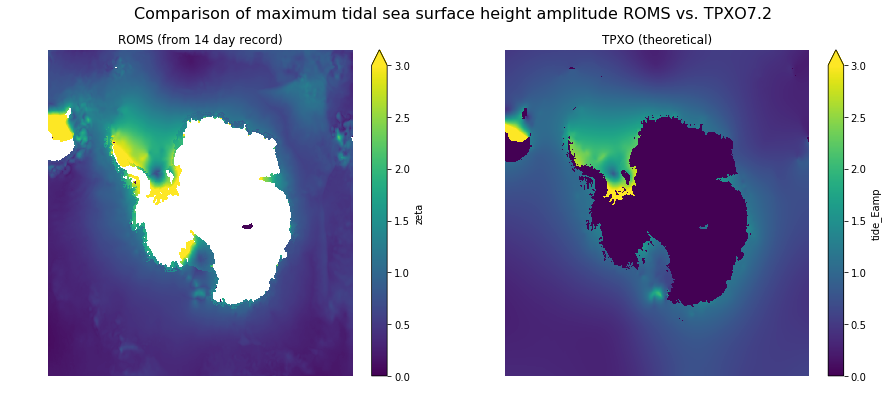

In [121]:
#look at results
file_path = os.path.join(os.pardir,'data','raw','waom10_tidal_mask','ocean_his_0001.nc')
ds_tm = xr.open_dataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
roms_ampl_max = ds_tm.zeta.max('ocean_time')-ds_tm.zeta.mean('ocean_time')

# plot against tpxo as before
plt.clf()
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Comparison of maximum tidal sea surface height amplitude ROMS vs. TPXO7.2',fontsize=16)
roms_ampl_max.fillna(0).plot(ax=ax1,vmax=3)
ax1.set_title('ROMS (from 14 day record)')
ax1.axis('off')
tpxo_ampl_max.tide_Eamp.plot(ax=ax2,vmax=3)
ax2.set_title('TPXO (theoretical)')
ax2.axis('off')
plt.show()

...seems to work, but we get this nasty gradients in SSH where the mask starts and next to the boundaries.

In [122]:
ds_tm['O1_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))
ds_tm['M2_ampl']=(('eta_rho','xi_rho'),np.zeros((ds.eta_rho.size,ds.xi_rho.size)))

#stime = datetime(1996,12,31,1)
stime = pd.to_datetime(ds_tm.ocean_time[0].values)

for xi in ds_tm.xi_rho.values:
    print('processing xi: ',xi)
    for eta in ds_tm.eta_rho.values:
        
        ds_sl = ds_tm.isel(eta_rho=eta,xi_rho=xi)
        
        if ds_sl.zeta.isnull().values.any():
            ds_tm.O1_ampl[eta,xi] = np.NaN
            ds_tm.M2_ampl[eta,xi] = np.NaN
        else:
            signal = ds_sl.zeta.values
            latitude = ds_sl.lat_rho.values
            try:
                ttide_out = tt.t_tide(signal,stime=stime,lat=latitude,out_style=None)

                ind_O1 = list(ttide_out['nameu']).index(b'O1  ')
                ind_M2 = list(ttide_out['nameu']).index(b'M2  ')
        
                O1_ampl = ttide_out['tidecon'][ind_O1][0]
                M2_ampl = ttide_out['tidecon'][ind_M2][0]
            
                ds_tm.O1_ampl[eta,xi] = O1_ampl
                ds_tm.M2_ampl[eta,xi] = M2_ampl
                
            except TypeError:
                
                ds_tm.O1_ampl[eta,xi] = np.NaN
                ds_tm.M2_ampl[eta,xi] = np.NaN

processing xi:  0
processing xi:  1
processing xi:  2
processing xi:  3
processing xi:  4
processing xi:  5
processing xi:  6
processing xi:  7
processing xi:  8
processing xi:  9
processing xi:  10
processing xi:  11
processing xi:  12


/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_tide.py:620: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:57: RuntimeWarning: invalid value encountered in true_divide
  snr = (tidecon[:, 0] / tidecon[:, 1]) ** 2
/home/ubuntu/bigStick/anaconda3/lib/python3.6/site-packages/ttide-0.3_exp-py3.6.egg/ttide/t_predic.py:60: RuntimeWarning: invalid value encountered in greater
  I = snr > synth


No predictions with this SNR
processing xi:  13
processing xi:  14
processing xi:  15
processing xi:  16
processing xi:  17
processing xi:  18
processing xi:  19
processing xi:  20
processing xi:  21
processing xi:  22
processing xi:  23
processing xi:  24
processing xi:  25
processing xi:  26
processing xi:  27
processing xi:  28
processing xi:  29
processing xi:  30
processing xi:  31
processing xi:  32
processing xi:  33
processing xi:  34
processing xi:  35
processing xi:  36
processing xi:  37
processing xi:  38
processing xi:  39
processing xi:  40
processing xi:  41
processing xi:  42
processing xi:  43
processing xi:  44
processing xi:  45
processing xi:  46
processing xi:  47
processing xi:  48
processing xi:  49
processing xi:  50
processing xi:  51
processing xi:  52
processing xi:  53
processing xi:  54
processing xi:  55
processing xi:  56
processing xi:  57
processing xi:  58
processing xi:  59
processing xi:  60
processing xi:  61
processing xi:  62
processing xi:  63
pr

processing xi:  426
processing xi:  427
processing xi:  428
processing xi:  429
processing xi:  430
processing xi:  431
processing xi:  432
processing xi:  433
processing xi:  434
processing xi:  435
processing xi:  436
processing xi:  437
processing xi:  438
processing xi:  439
processing xi:  440
processing xi:  441
processing xi:  442
processing xi:  443
processing xi:  444
processing xi:  445
processing xi:  446
processing xi:  447
processing xi:  448
processing xi:  449
processing xi:  450
processing xi:  451
processing xi:  452
processing xi:  453
processing xi:  454
processing xi:  455
processing xi:  456
processing xi:  457
processing xi:  458
processing xi:  459
processing xi:  460
processing xi:  461
processing xi:  462
processing xi:  463
processing xi:  464
processing xi:  465
processing xi:  466
processing xi:  467
processing xi:  468
processing xi:  469
processing xi:  470
processing xi:  471
processing xi:  472
processing xi:  473
processing xi:  474
processing xi:  475


processing xi:  836
processing xi:  837
processing xi:  838
processing xi:  839
processing xi:  840
processing xi:  841
processing xi:  842
processing xi:  843
processing xi:  844
processing xi:  845
processing xi:  846
processing xi:  847
processing xi:  848
processing xi:  849
processing xi:  850
processing xi:  851
processing xi:  852
processing xi:  853
processing xi:  854
processing xi:  855
processing xi:  856
processing xi:  857
processing xi:  858
processing xi:  859
No predictions with this SNR
No predictions with this SNR


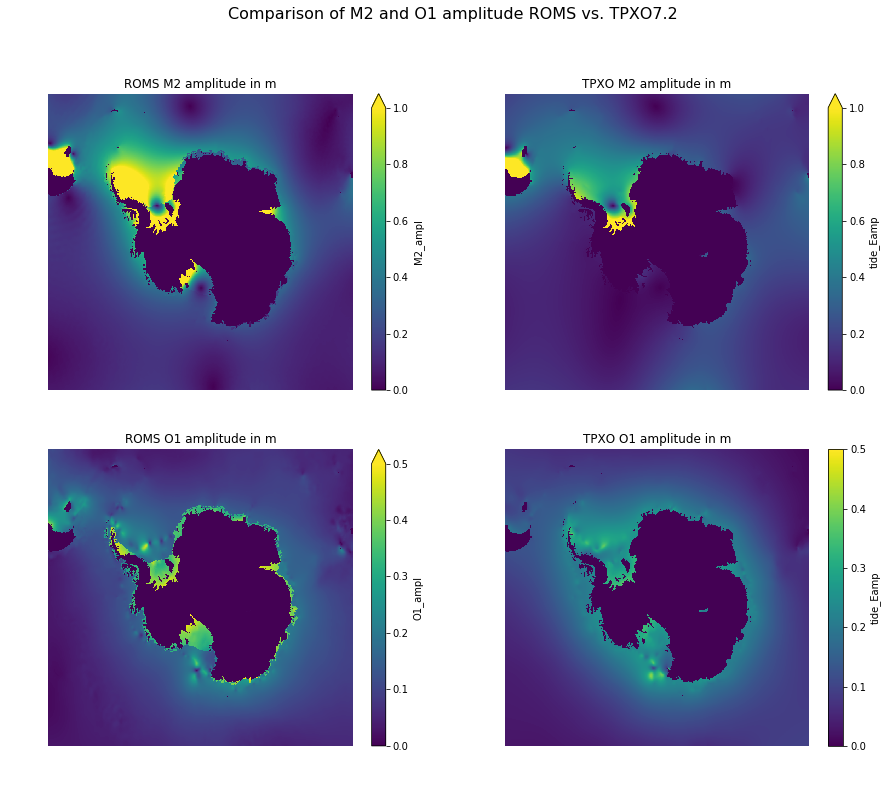

In [125]:
plt.close('all')
fig,axes = plt.subplots(2,2,figsize=(15,12))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude ROMS vs. TPXO7.2',fontsize=16)
ds_tm.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS M2 amplitude in m')
ax1.axis('off')
dsf.tide_Eamp[0].plot(ax=ax2,vmax=1)
ax2.set_title('TPXO M2 amplitude in m')
ax2.axis('off')
ds_tm.O1_ampl.fillna(0).plot(ax=ax3,vmax=0.5)
ax3.set_title('ROMS O1 amplitude in m')
ax3.axis('off')
dsf.tide_Eamp[5].plot(ax=ax4,vmax=0.5)
ax4.set_title('TPXO O1 amplitude in m')
ax4.axis('off')
plt.show()

In [ ]:
plt.close('all')
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(15,12))
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
fig.suptitle('Comparison of M2 and O1 amplitude ROMS vs. TPXO7.2',fontsize=16)
ds.M2_ampl.fillna(0).plot(ax=ax1,vmax=1)
ax1.set_title('ROMS full forcing M2 amplitude in m')
ax1.axis('off')
ds_tm.M2_ampl.fillna(0).plot(ax=ax2,vmax=1)
ax2.set_title('ROMS M2 mask iceshelf amplitude in m')
ax2.axis('off')
dsf.tide_Eamp[0].plot(ax=ax3,vmax=1)
ax3.set_title('TPXO M2 amplitude in m')
ax3.axis('off')
ds_tm.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
ax4.set_title('ROMS O1 full forcing amplitude in m')
ax4.axis('off')
ds_tm.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
ax5.set_title('ROMS O1 mask iceshelf amplitude in m')
ax5.axis('off')
dsf.tide_Eamp[5].plot(ax=ax6,vmax=0.5)
ax6.set_title('TPXO O1 amplitude in m')
ax6.axis('off')
plt.show()